# HW4: Bayesian Mixture Models


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Eric Weiner

**Names of any collaborators:** _Names here_

*Due: 11:59pm Monday, May 3, 2021 via GradeScope*

---

In this homework assignment we will investigate image segmentation ---specifically, separating the background from the foreground of the image. To do so, you'll learn Bayesian mixtures of Gaussians using Gibbs sampling.

### Background: Image Segmentation
The figure below shows the original input image and the resulting segmentations into background and foreground. By the end of this assignment, you will have implemented the algorithm to achieve this segmentation.

Reference on image segmentation: https://en.wikipedia.org/wiki/Image_segmentation

![Fox](images/fox_seg.png "Segmentation of fox image")


### Background: Non-Bayesian Mixtures

To set the stage, we begin with a straightforward finite mixture model to cluster the pixels (with the number of clusters $K = 2$ in our image segmentation problem). The likelihood of the model is defined as a mixture of Gaussian distributions.

$$
p(x_n \mid z_n, \{\mu_k, \Sigma_k\}_{k=1}^K) = \mathcal{N}(x_n; \mu_{z_n}, \Sigma_{z_n})
$$

where $x_n \in \mathbb{R}^D$ is distributed according to a Gaussian distribution with the specified mean, $\mu_k$, and covariance, $\Sigma_k$, for its correspondign cluster $z_n = k$. We will represent the images as a set of $N$ pixels, $\{x_n\}_{n=1}^N$, each in $D=3$ dimensional space, since there are three color channels (red, green, and blue).

### Bayesian Mixture

We specify the following priors on $\mu_k$, $\Sigma_k$, and $\pi$.
- Assume a normal-inverse-Wishart prior prior for each cluster mean and covariance.
\begin{align} 
p(\mu_k, \Sigma_k) &= \mathrm{IW}(\Sigma_k \mid \Psi_0, \nu_0) \, \mathcal{N}(\mu_k \mid m_0, \kappa_0^{-1} \Sigma_k)
\end{align}
Here $\Psi_0, \nu_0, m_0, \kappa_0$ are hyper-parameters.

- We give a symmetric Dirichlet distribution prior to the mixing proportions, $\pi$:
$$ 
p(\pi \mid \alpha) = \text{Dirichlet}(\alpha)
$$
with the hyper-parameter $\alpha$.

## Problem 1 [math]: posterior calculations
In this problem, you will derive the conditional posterior distributions of the various model parameters.

These are related to the joint posterior distribution:
$$
p(\pi, \{\mu_k, \Sigma_k\}_{k=1}^K, \{z_n\}_{n=1}^N \mid \{x_n\}_{n=1}^N, \alpha, \nu_0, \Psi_0, m_0, \kappa_0) 
\propto p(\pi \mid \alpha) \prod_{k=1}^K p(\mu_k, \Sigma_k \mid \nu_0, \Psi_0, m_0, \kappa_0) \prod_{n=1}^N p(z_n \mid \pi) p(x_n \mid \mu_{z_n}, \Sigma_{z_n})
$$


You will need these derivations to be correct for the implementation in Problem 2 to be correct, so we highly recommend taking the time to double check them.

### (a) Derive the complete conditional for the parameters $\mu_k, \Sigma_k$.
It should be a normal-inverse-Wishart distribution, like the prior.

The conditional distributions for $z_n$ and $\pi$ are the same as shown in lecture.


The complete conditional on parameters $\mu_k, \Sigma_k$ can be characterized as follows:

\begin{equation}
p(\mu_k, \Sigma_k | \nu_0, \Psi_0, m_0, \kappa_0, \{x_n\}_{n=1} ^N, \pi, \{z_n\}_{n=1} ^N) = \prod_{n:z_n = k}p(x_n |\mu_k, \Sigma_k)\times p(\mu_k, \Sigma_k | m_0, \nu_0, \Psi_0, \kappa_0)
\end{equation}

Where the first part is the the Gaussian likelihood and the second is the Inverse-Wishart prior.

Expanding this we see:

\begin{equation}
\left( \prod_{n:z_n = k}\frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2} }\text{exp} \Big\{-\frac{1}{2}(x_n - \mu_k)^T \Sigma_k^{-1}(x_n - \mu_k) \Big\}\right) \times \frac{\kappa_0^{1/2}}{(2\pi)^{d/2} |\Sigma_k|^{1/2}} \text{exp} \Big\{-\frac{1}{2}\kappa_0 (\mu_k - m_0)^T (\Sigma_k)^{-1}(\mu_k - m_0) \Big\} \times \frac{|\Psi_0|^{\nu_0/2}}{2^{\nu_0d/2}\Gamma_d(\nu_0/2)}|\Sigma_k|^{-(\nu_0 +d +1)/2} \text{exp} \Big\{-\frac{1}{2}\text{Tr}(\Psi_0 \Sigma_k^{-1}) \Big\}
\end{equation}



By combining constant terms out front and exponential terms we get the following:

\begin{equation}
Z \times |\Sigma_k|^{-1/2(n_k+\nu_0 +d +2)}\times \text{exp} \Big\{-\frac{1}{2} \left[ \sum_{n=1}^{N_k}\left(x_n - \mu_k)^T \Sigma_k^{-1}(x_n - \mu_k) \right) + \kappa_0(\mu_k - m_0)^T ( \Sigma_k)^{-1}(\mu_k - m_0) +\text{Tr}(\Psi_0 \Sigma_k^{-1})\right] \Big\}\\
\text{where, }
Z = \frac{|\Psi_0|^{\nu_0/2} \kappa_0^{1/2}}{(2\pi)^{d/2(n_k+1)}}
\end{equation}

We know that the posterior is of the form of a Normal-inverse-Wishart. Namely, it should look something like the following:

\begin{equation}
Z' \times |\Sigma_k|^{-1/2(\nu' +d +2)}\times \text{exp} \Big\{-\frac{1}{2}\left[\kappa '(\mu_k - m')^T ( \Sigma_k)^{-1}(\mu_k - m') +\text{Tr}(\Psi ' \Sigma_k^{-1})\right] \Big\}
\end{equation}

Upon inspection, we see that $\nu ' = \nu_0 + n_k$

We can see that up to a constant, terms with  $\nu$ only appear in the $\Sigma_k$ term out front. Thus, we can neglect the terms with $Z$ and $|\Sigma_k|$ now need to equate the following:

\begin{equation}
\text{exp} \Big\{-\frac{1}{2} \left[ \sum_{n=1}^{N_k}\left(x_n - \mu_k)^T \Sigma_k^{-1}(x_n - \mu_k) \right) + \kappa_0 (\mu_k - m_0)^T (\Sigma_k)^{-1}(\mu_k - m_0) +\text{Tr}(\Psi_0 \Sigma_k^{-1})\right] \Big\} = \text{exp} \Big\{-\frac{1}{2}\left[\kappa '(\mu_k - m')^T ( \Sigma_k)^{-1}(\mu_k - m') +\text{Tr}(\Psi ' \Sigma_k^{-1})\right] \Big\}
\end{equation}

Below, I expand the parts that do not include the trace.

\begin{equation}
\sum_{n=1}^{N_k} \left(x_n - \mu_k)^T \Sigma_k^{-1}(x_n - \mu_k) \right) + \kappa_0 (\mu_k - m_0)^T (\Sigma_k)^{-1}(\mu_k - m_0) = \\ \sum_{n=1}^{N_k}x_n^T \Sigma_k^{-1}x_n - 2\mu_k^T\Sigma_k^{-1}(\Sigma_k^{N_k}x_n)+n_k\mu_k^T\Sigma_k^{-1}\mu_k + \kappa_0\mu_k^T\Sigma_k^{-1}\mu_k -2\kappa_0\mu_k^T\Sigma_k^{-1}m_0+\kappa_0m_0^T\Sigma_k^{-1}m_0 =
\end{equation}

Combining some like terms

\begin{equation}
 (\kappa_0 + n_k)(\mu_k^T\Sigma_k^{-1}\mu_k) - (\kappa_0m_0 + \Sigma_{n=1}^{N_k})(2\mu_k^T\Sigma_k^{-1}) + \sum_{n=1}^{N_k}x_n^T\Sigma_k^{-1}x_n + \kappa_0m_0^T\Sigma_k^{-1}m_0
\end{equation}

If we expand $\kappa '(\mu_k - m')^T ( \Sigma_k)^{-1}(\mu_k - m')$, we get the following:

\begin{equation}
\kappa '(\mu_k - m')^T ( \Sigma_k)^{-1}(\mu_k - m') = \kappa'\mu_k^T\Sigma_k^{-1}\mu_k - 2\kappa'\mu_k^T\Sigma_k^{-1}m' + \kappa'm'^T\Sigma_k^{-1}m'
\end{equation}

By pattern matching, we can see the following:

\begin{equation}
\kappa' = \kappa_0 +n_k \\
m' = \frac{1}{\kappa_0+n_k} \left(\kappa_0m_0 + \sum_{n=1}^{N_k}x_n \right)
\end{equation}

The parts that are left to match are the following:

\begin{equation}
\sum_{n=1}^{N_k}x_n^T\Sigma_k^{-1}x_n + \kappa_0m_0^T\Sigma_k^{-1}m_0 - \kappa'm'^T\Sigma_k^{-1}m'+ \text{Tr}(\Psi\Sigma_k^{-1})= \text{Tr}(\Psi'\Sigma_k^{-1})
\end{equation}

Taking the trace of both sides we get the following:


\begin{equation}
\sum_{n=1}^{N_k}\text{Tr}\left(x_n^T\Sigma_k^{-1}x_n \right) + \text{Tr}(\kappa_0m_0^T\Sigma_k^{-1}m_0) - \text{Tr}(\kappa'm'^T\Sigma_k^{-1}m')+ \text{Tr}(\Psi\Sigma_k^{-1})= \text{Tr}(\Psi'\Sigma_k^{-1})
\end{equation}

Using the properties of the Trace of a matrix, we can rearrange some of the terms inside:

\begin{equation}
\sum_{n=1}^{N_k}\text{Tr}\left(x_nx_n^T\Sigma_k^{-1} \right) + \text{Tr}(\kappa_0m_0m_0^T\Sigma_k^{-1}) - \text{Tr}(\kappa'm'm'^T\Sigma_k^{-1})+ \text{Tr}(\Psi\Sigma_k^{-1})= \text{Tr}(\Psi'\Sigma_k^{-1})
\end{equation}

After some more rearranging:

\begin{equation}
\text{Tr}\left(\Big[\sum_{n=1}^{N_k}x_nx_n^T + \kappa_0m_0m_0^T - \kappa'm'm'^T+ \Psi\Big]\Sigma_k^{-1}\right)= \text{Tr}(\Psi'\Sigma_k^{-1})
\end{equation}

Finally, we have


\begin{equation}
\Psi_k' = \sum_{n=1}^{N_k}x_nx_n^T + \kappa_0m_0m_0^T - \kappa'm'm'^T+ \Psi
\end{equation}

## Problem 2: Gibbs Sampler
We have provided starter code below.
- First, you need to fill it with your own implementation of the Gibbs sampling algorithm. You may not rely on external implementations such as those offered by Tensorflow or scikit-learn.
- Then, you will test your code on a simple example.

### (a) Implement the Gibbs Sampler 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [650]:
from scipy.stats import multivariate_normal

##This code below is the likelihood calculation of the data given the parameters. We have this as a 
##Normal(x_n, mu_z_n, Sigma_z_n)

def lh_probs(X, mu, sigma):
    probs = multivariate_normal.pdf(X, mean=mu, cov=sigma)
    return probs

#the coding portion below describes getting the probability of class 1 from the z_n complete conditional
def class_prob(pi_1, pi_2, mu_k1, sig_k1, mu_k2, sig_k2,X):
    num = lh_probs(X, mu_k1, sig_k1)*pi_1
    denom = lh_probs(X, mu_k1, sig_k1)*pi_1 + lh_probs(X,mu_k2, sig_k2)*pi_2
    prob_k1 = np.reshape(num/denom, (len(X),1))
    prob_k2 = np.reshape(1 - prob_k1, (len(X),1))
    return np.concatenate((prob_k1, prob_k2), axis =1)
    


###This coding portion implements sampling from z
###THIS ASSIGNS A VALUE POINT TO CLASS 1 IF ABOE THE THRESHOLD
### AN OUTPUT MEANS IT DID NOT PASS THE TEST AND IS ASSIGNED TO CLASS 2
  
def sample_z(pi_1, pi_2, mu_k1, sig_k1, mu_k2, sig_k2,X):
    
    probs = class_prob(pi_1, pi_2, mu_k1, sig_k1, mu_k2, sig_k2,X)
    rvs_compare = np.random.rand(len(X))
    z_new = probs[:,0] > rvs_compare
    #np.random.choice([0,1], p =probs)
    return np.reshape(z_new.astype(int), (len(X),1))



Z_test = np.random.choice([0,1],p = [0.5, 0.5], size =100)
testing = sample_z(0.5,0.5, random.choice(X_test), np.eye(3), random.choice(X_test), np.eye(3),X_test)
testing_probs = class_prob(0.5,0.5, random.choice(X_test), np.eye(3), random.choice(X_test), np.eye(3),X_test)
testing_matrix=np.concatenate((testing_probs, testing), axis =1)
#testing
#print(np.unique(testing, return_counts=True))

In [651]:
##this coding chunk describes step 2 of the gibbs sampler: sampling new mu_k and sigma_k
import pandas as pd
from scipy.stats import invwishart

Psi0 = np.eye(3)

def psi_pr(X,Z,k):
    temp = pd.DataFrame(data = np.concatenate((X,Z), axis =1))
    n_k = (temp[temp[3] == k].iloc[:,3]).count()
    subset_df = temp[temp[3] == k].iloc[:,:-1]
    term1 = subset_df.T@subset_df
    
    term2 = kappa0*np.reshape(m0,(3,1))@np.reshape(m0,(3,1)).T
    
    term3 = kappa_pr(X,Z,k)*np.reshape(m_pr(X,Z,k),(3,1))@np.reshape(m_pr(X,Z,k),(3,1)).T
    return term1 + term2 - term3 + Psi0
  
def nu_pr(X,Z,k):
    temp = pd.DataFrame(data = np.concatenate((X,Z), axis =1))
    n_k = (temp[temp[3] == k].iloc[:,3]).count()
    return nu0 + n_k


def kappa_pr(X,Z,k):
    temp = pd.DataFrame(data = np.concatenate((X,Z), axis =1))
    n_k = (temp[temp[3] == k].iloc[:,3]).count()
    return kappa0 + n_k

def m_pr(X,Z,k):
    temp = pd.DataFrame(data = np.concatenate((X,Z), axis =1))
    n_k = (temp[temp[3] == k].iloc[:,3]).count()
    subset_df = temp[temp[3] == k].iloc[:,:-1]
    
    m_prime = (1/(kappa0 + n_k))*(kappa0*m0 + np.sum(subset_df).to_numpy())
    return  m_prime

def sample_mk_sigk(X, Z ,k):
    sig_k = invwishart.rvs(df = nu_pr(X, Z, k), scale =psi_pr(X,Z,k) ,size =1)
    mu_k_new = multivariate_normal.rvs(m_pr(X,Z,k), cov=sig_k/kappa_pr(X, Z,k), size=1, random_state=None)
    return mu_k_new, sig_k


#Z_test = np.reshape(np.random.randint(2, size=100), (100,1))
#print(sample_mk_sigk(X_test, Z_test,0))
#print(sample_mk_sigk(X_test, Z_test,1))
#print(psi_pr(X_test, Z_test, 0))
#print(psi_pr(X_test, Z_test, 1))
#m_pr(X_test, Z_test, 0)

In [652]:
##this coding chunk describes step 3 of the gibbs sampler: sampling new mixing proportions

from scipy.stats import dirichlet
alpha=np.ones(2)
def sample_prop(X, Z):
    temp = pd.DataFrame(data = np.concatenate((X,Z), axis =1))
    nk1 = (temp[temp[3] == 1].iloc[:,3]).count()
    nk2 = (temp[temp[3] == 0].iloc[:,3]).count()
    alphas = alpha + np.array([nk1, nk2])
    proportions = dirichlet.rvs(alphas, size =1)
    return proportions, alphas

#sample_prop(X_test, Z_test)[0,1]
#blah = sample_prop(X_test, Z_test)
#print(blah)
#print(blah[0,0])

In [828]:
import random

def ljp(props,as_new, mu_k1, sig_k1, mu_k2, sig_k2,X, Z ):
    quantiles = props  # specify quantiles
    alpha = as_new  # specify concentration parameters
    log_pi_alpha = np.log(dirichlet.pdf(quantiles, alpha))
    log_mu_sig_1 = np.log(invwishart.pdf(sig_k1,df = nu0, scale =Psi0)*multivariate_normal.pdf(mu_k1, m0, cov=sig_k1))
    log_mu_sig_2 = np.log(invwishart.pdf(sig_k2,df = nu0, scale =Psi0)*multivariate_normal.pdf(mu_k2, m0, cov=sig_k2))
    
    temp = pd.DataFrame(data = np.concatenate((X,Z), axis =1))
    n_k1 = (temp[temp[3] == 1].iloc[:,3]).count()
    n_k2 = (temp[temp[3] == 0].iloc[:,3]).count()
    log_pi_1 = np.sum(np.log(props[0,0]))*n_k1
    log_pi_2 = np.sum(np.log(props[0,1]))*n_k2
    subset_df2 = temp[temp[3] == 0].iloc[:,:-1]
    subset_df1 = temp[temp[3] == 1].iloc[:,:-1]
    log_x_1 = np.sum(np.log(multivariate_normal.pdf(subset_df1, mu_k1, cov = sig_k1)))
    log_x_2 = np.sum(np.log(multivariate_normal.pdf(subset_df2, mu_k2, cov = sig_k2)))
    
    total = log_pi_alpha + log_mu_sig_1 + log_mu_sig_2 + log_pi_1 + log_pi_2 + log_x_1 + log_x_2
    return total, log_pi_alpha


#sampled_muk1 = np.zeros((len(n_iter), 3))
#sampled_muk2 = np.zeros((len(n_iter), 3))



def gibbs(X, K, 
          n_iter, 
          alpha, 
          m0, 
          kappa0, 
          nu0, 
          Psi0):
    
    sampled_muk1 = []
    sampled_muk2 = []

    sampled_sigmak1 = []
    sampled_sigmak2 = []
    sampled_proportions = []
    
    sampled_assignments = []

    log_joint_probs = []
    #sampled_assignments = np.zeros((len(X_test), n_iter))
    initial_props = np.reshape(np.array([0.5, 0.5]), (1,2))
    props = initial_props
    mu_k1 = random.choice(X)
    mu_k2 = random.choice(X)
    sig_k1 = np.eye(3)
    sig_k2 =  np.eye(3)
    for i in range(n_iter):
        #print(f"the iteration is {i}.")
        #print(mu_k1)
        new_z = np.array(sample_z(props[0,0], props[0,1], mu_k1, sig_k1, mu_k2, sig_k2,X))
        #print(np.unique(new_z, return_counts=True))
        sampled_assignments.append(new_z)
        #print(f"the sampled assignment is {new_z} .")
        #print(i)
        #print(f"the mixing proportions are {props} .")
        ## Sampling mu and sigma for each class
        mu_k2, sig_k2 = sample_mk_sigk(X,new_z,0)
        mu_k1, sig_k1 = sample_mk_sigk(X,new_z,1)
        
        sampled_muk1.append(mu_k1)
        sampled_muk2.append(mu_k2)
        
        sampled_sigmak1.append(sig_k1)
        sampled_sigmak2.append(sig_k2)
        #print(f"mu_k1 is {muk1} .")
        #print(f"mu_k2 is {muk2} .")
        ## Sampling proportions
        
        props, as_new = sample_prop(X,new_z)
        
        #print(props)
        sampled_proportions.append(np.asarray(props))
        #return sampled_proportions, sampled_assignments, sampled_muk1, sampled_sigmak1, sampled_muk2, sampled_sigmak2
        ljps = ljp(props,as_new, mu_k1, sig_k1, mu_k2, sig_k2,X, new_z)
        
        log_joint_probs.append(ljps)
    return np.asarray(sampled_assignments), np.asarray(sampled_muk1, dtype = np.float32), \
           np.asarray(sampled_muk2, dtype = np.float32),np.asarray(log_joint_probs, dtype = np.float32)
    """
    Run the Gibbs samlper for a mixture of Gaussians with a NIW prior.
    
    Input:
    - X: Matrix of size (N, D). Each row of X stores one data point
    - K: the desired number of clusters in the model. Default: 2
    - n_iter: number of iterations of Gibbs sampling. Default: 100
    - alpha: hyperparameter of the Dirichlet prior on \pi.
    - m0, kappa0, nu0, Psi0, hyperparameters of normal-inverse-Wishart prior.
        
    Returns: 
    - log joint probability for each iteration
    - samples of parameters and assignments over iterations
    
    You will use these values later on for convergence diagnostics.
    """
    




### (b) test your implementation 
Test your example on a synthetic data set.

For example, the ground truth could be two clusters, with means [5,5,5] and [8,8,8] respectively. You could generate $50$ points in each cluster. 

Whichever example you choose, be sure to specify it and show that your implementation roughly recovers the ground truth by displaying the cluster means/covariances and trace plots of the log joint probability.

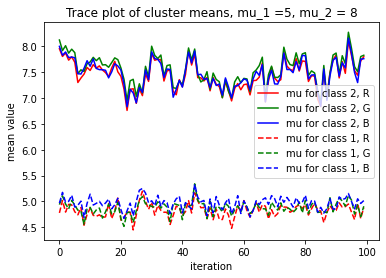

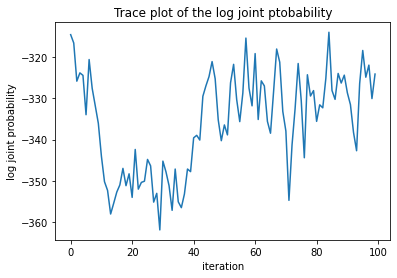

In [814]:
from scipy.stats import multivariate_normal

cluster1 = multivariate_normal.rvs(mean=[5,5,5], cov=0.1*np.eye(3), size=50, random_state=None)
cluster2 = multivariate_normal.rvs(mean=[8,8,8], cov=0.1*np.eye(3), size=50, random_state=None)

X_test = np.concatenate((cluster1, cluster2), axis = 0)


assign, muk1, ljps_for_graph = gibbs(X_test, K=2, 
          n_iter=100, 
          alpha=np.ones(2), 
          m0=np.zeros(3), 
          kappa0=1.0, 
          nu0=5.0, 
          Psi0=np.eye(3))



testing_muk1 = np.asarray(sampled_muk1, dtype=np.float32)
testing_muk2 = np.asarray(sampled_muk2, dtype=np.float32)
#plt.plot(testing_muk1[:,0])
plt.plot(testing_muk2[:,0], label = "mu for class 2, R", color = 'red')
plt.plot(testing_muk2[:,1], label = "mu for class 2, G",color = 'green')
plt.plot(testing_muk2[:,2], label = "mu for class 2, B", color = 'blue')
plt.plot(testing_muk1[:,0], label = "mu for class 1, R", color = "red", linestyle = "dashed")
plt.plot(testing_muk1[:,1], label = "mu for class 1, G", color = "green", linestyle = "dashed")
plt.plot(testing_muk1[:,2], label = "mu for class 1, B", color = "blue", linestyle = "dashed")
plt.title("Trace plot of cluster means, mu_1 =5, mu_2 = 8")
plt.xlabel("iteration")
plt.ylabel("mean value")
plt.legend()
plt.show()

#ljps_for_graph = np.asarray(log_joint_probs, dtype=np.float32)

plt.plot(ljps_for_graph[:,0])
plt.title("Trace plot of the log joint ptobability")
plt.xlabel("iteration")
plt.ylabel("log joint probability")
plt.show()

## Problem 3 : Perform image segmentation
Now that you have implemented the Gibbs Sampler, you are ready to perform image segmentation!
First, we define helper code to load the images and save the segmentation.

In [845]:
def load_image(filename):
    # Read in the image, dropping the alpha channel
    image = plt.imread(filename + ".png")[:, :, :3]
    plt.imshow(image)

    # get height, width and number of channels
    H, W, C = image.shape
    X = image.copy().astype(float)
    
    # reshape into pixels, each has 3 channels (RGB)
    X = X.reshape((H * W, C)) 
    return image, X, H, W, C

def save_segmentation(H, W, C,K,image, assignments, filename=None):
    fig, axs = plt.subplots(1, K + 1, figsize=(4 * (K + 1), 4))
    axs[0].imshow(image)
    axs[0].set_axis_off()
    axs[0].set_title("original image")
    #assignments = assignments[niter-1]
    for k in range(K):
        im = image.copy()
        #print(np.shape(im))
        #im = np.reshape(im,((H*W),C))
        #print(np.shape(assignments))
        #print(np.shape(im))
        
        assignments = np.reshape(assignments,((H,W)))
        #print(np.shape(assignments))
        im[assignments != k] = 0
        #print(np.shape(im))
        #im = im.reshape((H,W,C))
        axs[k+1].imshow(im)
        axs[k+1].set_axis_off()
        axs[k+1].set_title("component {}".format(k))
        #sumcomp = np.sum(im)
        #print(f"The sum of components is{sumcomp}")
    if filename is not None:
        plt.savefig(filename)
        
        

#### Run the Gibbs sampler
Run the Gibbs sampler on the 4 provided images: "cow", "fox", "owl", "zebra". The hyper-parameters values should be the default ones from the Gibbs function.

Each sample of $\{z_n\}_{n=1}^N$ is a segmentation. To aggregate them into one sample, you could assign each pixel to the component it was most often attributed to in your samples.

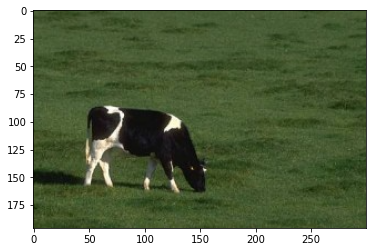

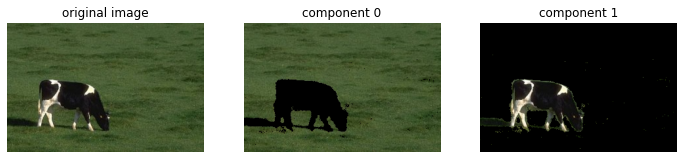

In [846]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

image_cow, X_cow, H_cow, W_cow, C_cow = load_image("/Users/ericgarc/Desktop/Stanford/Spring 2021/STATS 271/HW 4/cow")
assignments_cow1, muk1_cow, muk2_cow, ljps_cow = gibbs(X_cow, K=2, 
          n_iter=50, 
          alpha=np.ones(2), 
          m0=np.zeros(3), 
          kappa0=1.0, 
          nu0=5.0, 
          Psi0=np.eye(3))

assignments_cow_last = assignments_cow1[49]
save_segmentation(H_cow, W_cow, C_cow, 2,image_cow, assignments_cow_last, filename=None)




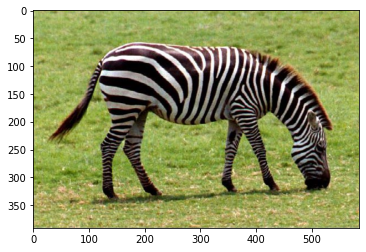

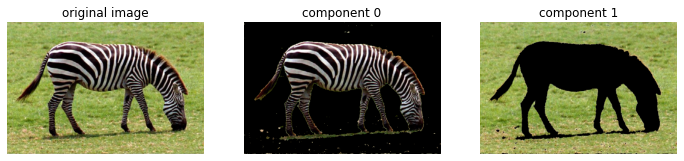

In [876]:
image_zebra, X_zebra, H_zebra, W_zebra, C_zebra = load_image("/Users/ericgarc/Desktop/Stanford/Spring 2021/STATS 271/HW 4/zebra")
assignments_zebra1, muk1_zebra, muk2_zebra, ljps_zebra = gibbs(X_zebra, K=2, 
          n_iter=100, 
          alpha=np.ones(2), 
          m0=np.zeros(3), 
          kappa0=1.0, 
          nu0=5.0, 
          Psi0=np.eye(3))

assignments_zebra_last = assignments_zebra1[99]
save_segmentation(H_zebra, W_zebra, C_zebra, 2,image_zebra, assignments_zebra_last, filename=None)



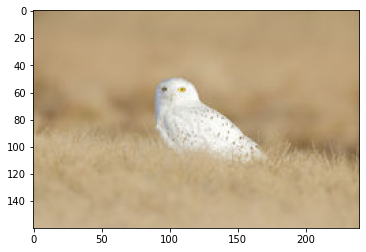

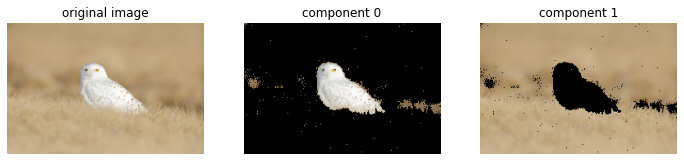

In [872]:
image_owl, X_owl, H_owl, W_owl, C_owl = load_image("/Users/ericgarc/Desktop/Stanford/Spring 2021/STATS 271/HW 4/owl")
assignments_owl1, muk1_owl, muk2_owl, ljps_owl = gibbs(X_owl, K=2, 
          n_iter=100, 
          alpha=np.ones(2), 
          m0=np.zeros(3), 
          kappa0=1.0, 
          nu0=5.0, 
          Psi0=np.eye(3))

assignments_owl_last = assignments_owl1[99]
save_segmentation(H_owl, W_owl, C_cow, 2,image_owl, assignments_owl_last, filename=None)




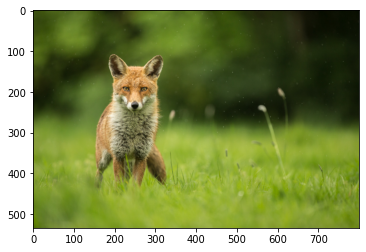

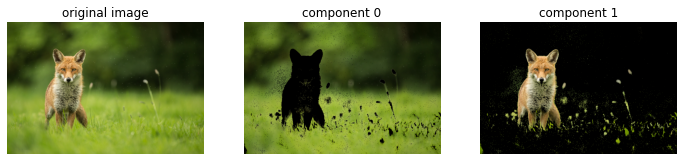

In [885]:
image_fox, X_fox, H_fox, W_fox, C_fox = load_image("/Users/ericgarc/Desktop/Stanford/Spring 2021/STATS 271/HW 4/fox")
assignments_fox1, muk1_fox, muk2_fox, ljps_fox = gibbs(X_fox, K=2, 
          n_iter=100, 
          alpha=np.ones(2), 
          m0=np.zeros(3), 
          kappa0=1.0, 
          nu0=5.0, 
          Psi0=np.eye(3))

assignments_fox_last = assignments_fox1[99]
save_segmentation(H_fox, W_fox, C_fox, 2,image_fox, assignments_fox_last, filename=None)




## Problem 4: Diagnostics
### (a)
Make trace plots of the log joint probability and posterior marginals of the cluster means (e.g. as histograms for R, G, and B weights.)

### (b)
(Approximately) how many iterations are needed for convergence? Does this depend on the input image and/or initialization of the model parameters?


Text(0.5, 1.0, 'Blue')

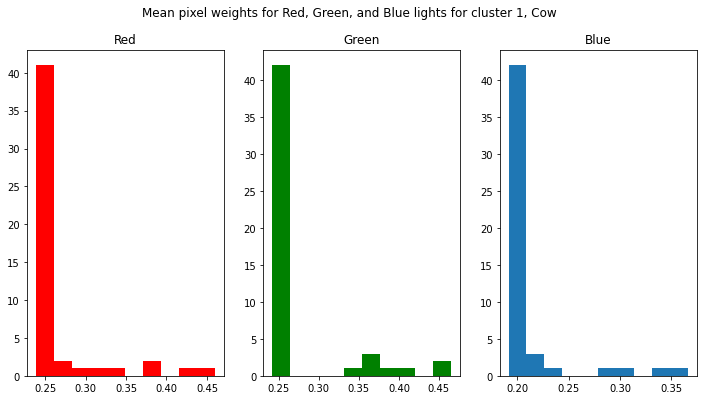

In [849]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,6))
fig.suptitle('Mean pixel weights for Red, Green, and Blue lights for cluster 1, Cow ')
ax1.hist(muk1_cow[:,0], color = "Red")
ax2.hist(muk1_cow[:,1], color = "Green")
ax3.hist(muk1_cow[:,2])

ax1.set_title('Red')
ax2.set_title('Green')
ax3.set_title('Blue')



Text(0.5, 1.0, 'Blue')

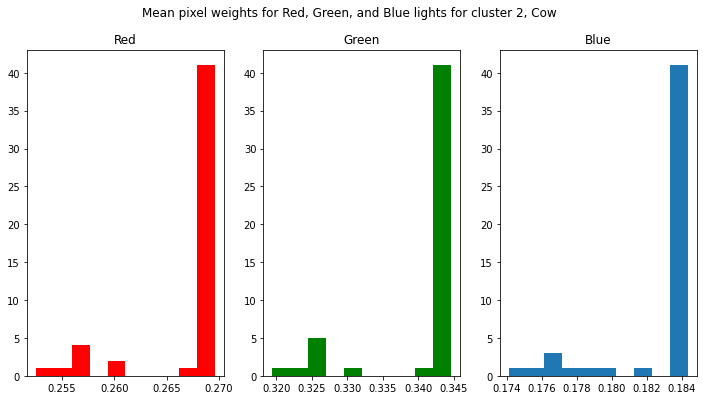

In [850]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,6))
fig.suptitle('Mean pixel weights for Red, Green, and Blue lights for cluster 2, Cow ')
ax1.hist(muk2_cow[:,0], color = "Red")
ax2.hist(muk2_cow[:,1], color = "Green")
ax3.hist(muk2_cow[:,2])

ax1.set_title('Red')
ax2.set_title('Green')
ax3.set_title('Blue')


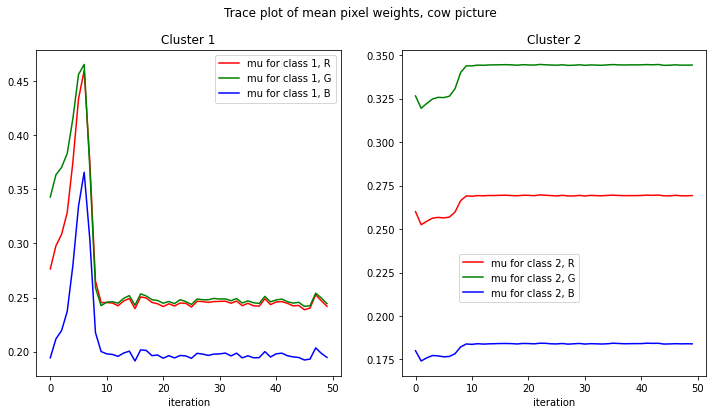

In [868]:
##cow diagnostics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
fig.suptitle('Trace plot of mean pixel weights, cow picture')
ax1.plot(muk1_cow[:,0], color = "Red",label = "mu for class 1, R")
ax1.plot(muk1_cow[:,1], color = "Green", label = "mu for class 1, G")
ax1.plot(muk1_cow[:,2], color ="Blue", label = "mu for class 1, B")


ax2.plot(muk2_cow[:,0], color = "Red", label = "mu for class 2, R")
ax2.plot(muk2_cow[:,1], color = "Green", label = "mu for class 2, G")
ax2.plot(muk2_cow[:,2], color ="Blue", label = "mu for class 2, B")


ax1.set_title('Cluster 1')
ax2.set_title('Cluster 2')
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')

ax1.legend()
ax2.legend(loc = 5, bbox_to_anchor = (0.6,0.3))

Text(0.5, 1.0, 'Blue')

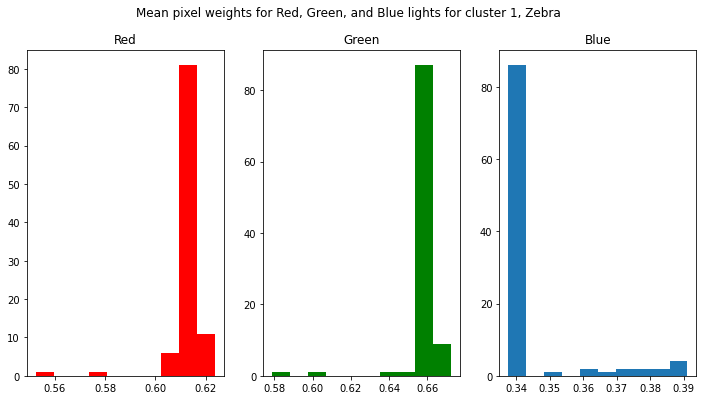

In [877]:
##zebra diagnostics

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,6))
fig.suptitle('Mean pixel weights for Red, Green, and Blue lights for cluster 1, Zebra ')
ax1.hist(muk1_zebra[:,0], color = "Red")
ax2.hist(muk1_zebra[:,1], color = "Green")
ax3.hist(muk1_zebra[:,2])

ax1.set_title('Red')
ax2.set_title('Green')
ax3.set_title('Blue')




Text(0.5, 1.0, 'Blue')

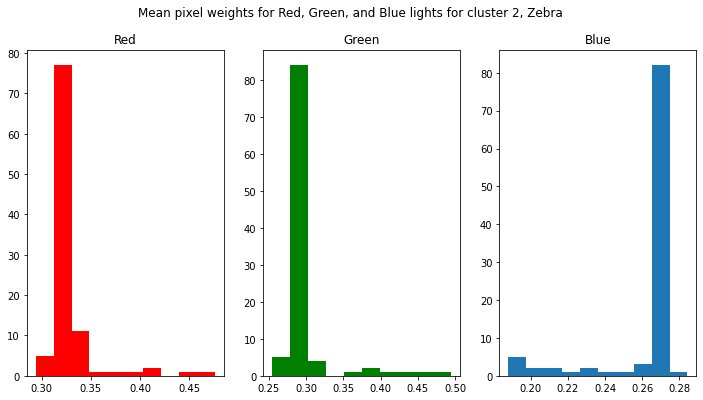

In [878]:
#zebra diagnostics cluster 2

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,6))
fig.suptitle('Mean pixel weights for Red, Green, and Blue lights for cluster 2, Zebra')
ax1.hist(muk2_zebra[:,0], color = "Red")
ax2.hist(muk2_zebra[:,1], color = "Green")
ax3.hist(muk2_zebra[:,2])

ax1.set_title('Red')
ax2.set_title('Green')
ax3.set_title('Blue')

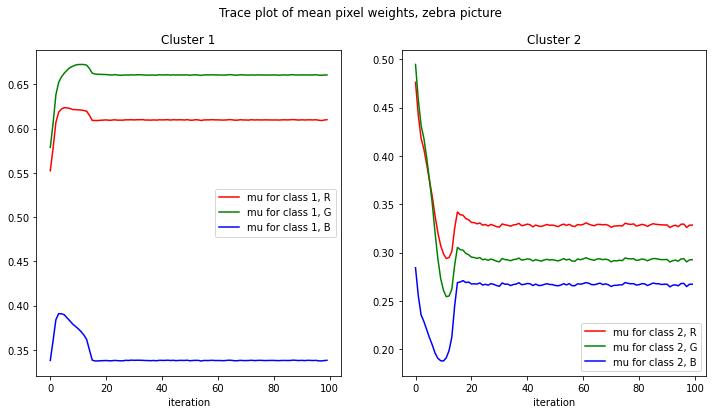

In [883]:
##zebra diagnostics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
fig.suptitle('Trace plot of mean pixel weights, zebra picture')
ax1.plot(muk1_zebra[:,0], color = "Red",label = "mu for class 1, R")
ax1.plot(muk1_zebra[:,1], color = "Green", label = "mu for class 1, G")
ax1.plot(muk1_zebra[:,2], color ="Blue", label = "mu for class 1, B")


ax2.plot(muk2_zebra[:,0], color = "Red", label = "mu for class 2, R")
ax2.plot(muk2_zebra[:,1], color = "Green", label = "mu for class 2, G")
ax2.plot(muk2_zebra[:,2], color ="Blue", label = "mu for class 2, B")


ax1.set_title('Cluster 1')
ax2.set_title('Cluster 2')
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')

ax1.legend()
ax2.legend(loc = 4)

Text(0.5, 1.0, 'Blue')

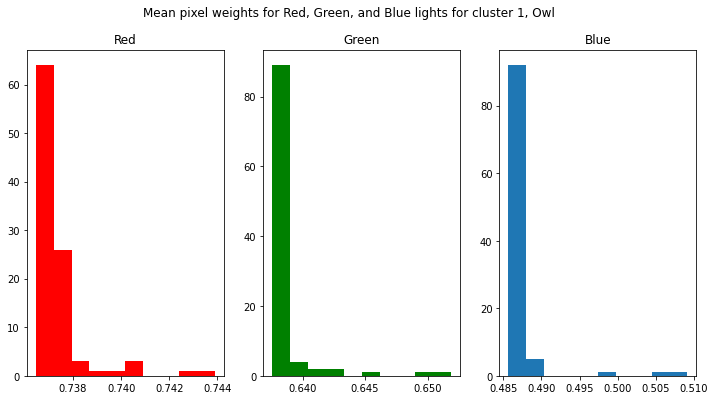

In [880]:
##owl diagnostics cluster 1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,6))
fig.suptitle('Mean pixel weights for Red, Green, and Blue lights for cluster 1, Owl ')
ax1.hist(muk1_owl[:,0], color = "Red")
ax2.hist(muk1_owl[:,1], color = "Green")
ax3.hist(muk1_owl[:,2])

ax1.set_title('Red')
ax2.set_title('Green')
ax3.set_title('Blue')



Text(0.5, 1.0, 'Blue')

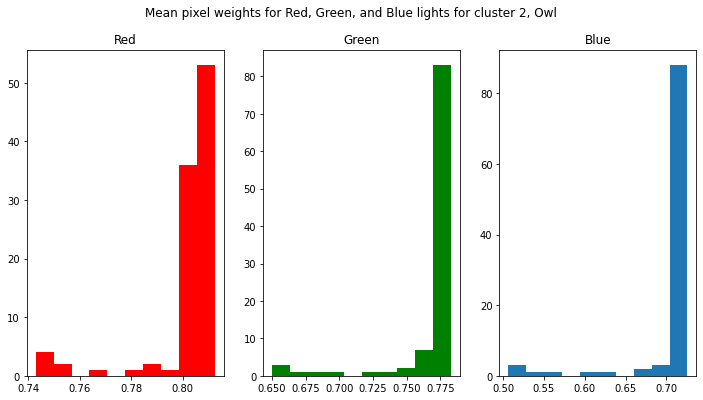

In [881]:
#owl diagnostics cluster 2

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,6))
fig.suptitle('Mean pixel weights for Red, Green, and Blue lights for cluster 2, Owl')
ax1.hist(muk2_owl[:,0], color = "Red")
ax2.hist(muk2_owl[:,1], color = "Green")
ax3.hist(muk2_owl[:,2])

ax1.set_title('Red')
ax2.set_title('Green')
ax3.set_title('Blue')

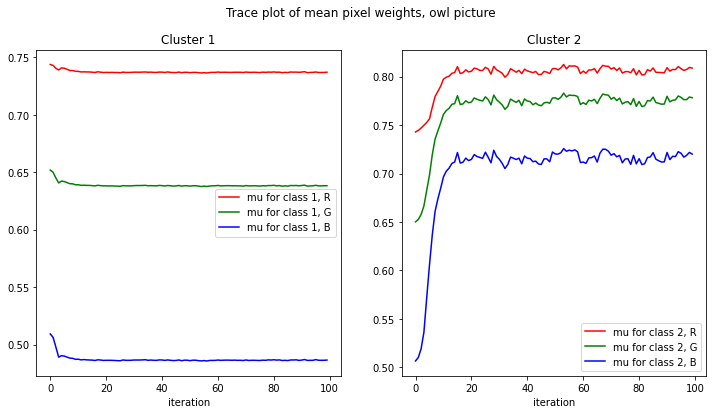

In [884]:
##owl diagnostics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
fig.suptitle('Trace plot of mean pixel weights, owl picture')
ax1.plot(muk1_owl[:,0], color = "Red",label = "mu for class 1, R")
ax1.plot(muk1_owl[:,1], color = "Green", label = "mu for class 1, G")
ax1.plot(muk1_owl[:,2], color ="Blue", label = "mu for class 1, B")


ax2.plot(muk2_owl[:,0], color = "Red", label = "mu for class 2, R")
ax2.plot(muk2_owl[:,1], color = "Green", label = "mu for class 2, G")
ax2.plot(muk2_owl[:,2], color ="Blue", label = "mu for class 2, B")


ax1.set_title('Cluster 1')
ax2.set_title('Cluster 2')
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')

ax1.legend()
ax2.legend(loc = 4)

Text(0.5, 1.0, 'Blue')

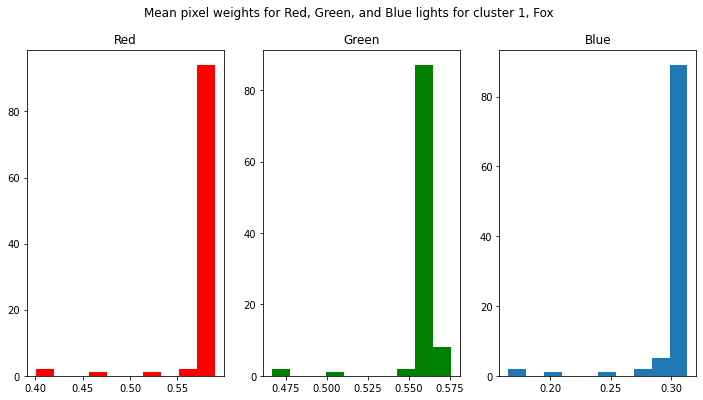

In [886]:
##fox diagnostics cluster 1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,6))
fig.suptitle('Mean pixel weights for Red, Green, and Blue lights for cluster 1, Fox ')
ax1.hist(muk1_fox[:,0], color = "Red")
ax2.hist(muk1_fox[:,1], color = "Green")
ax3.hist(muk1_fox[:,2])

ax1.set_title('Red')
ax2.set_title('Green')
ax3.set_title('Blue')


Text(0.5, 1.0, 'Blue')

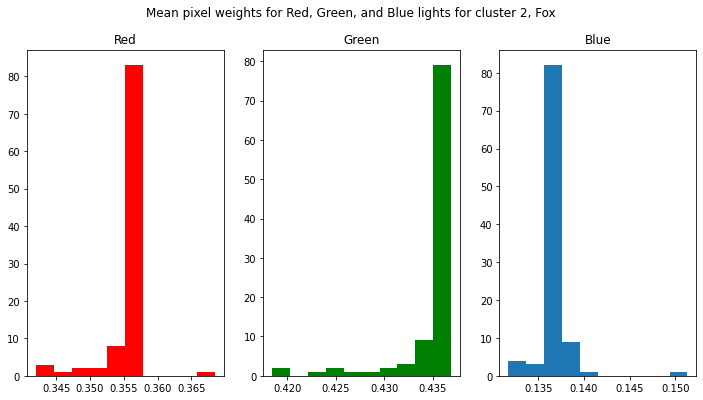

In [887]:
#fox diagnostics cluster 2

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,6))
fig.suptitle('Mean pixel weights for Red, Green, and Blue lights for cluster 2, Fox')
ax1.hist(muk2_fox[:,0], color = "Red")
ax2.hist(muk2_fox[:,1], color = "Green")
ax3.hist(muk2_fox[:,2])

ax1.set_title('Red')
ax2.set_title('Green')
ax3.set_title('Blue')

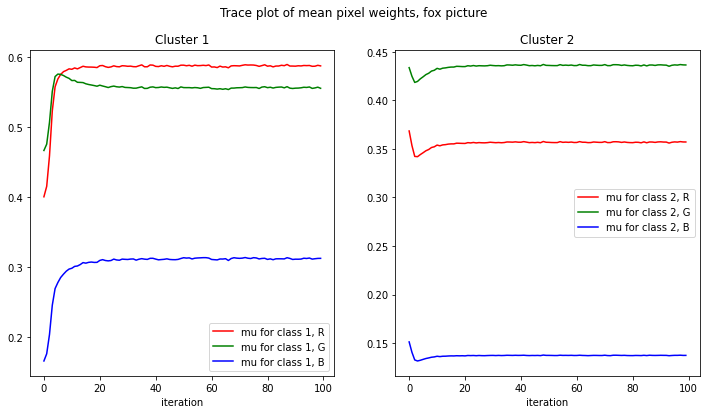

In [890]:
##fox diagnostics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
fig.suptitle('Trace plot of mean pixel weights, fox picture')
ax1.plot(muk1_fox[:,0], color = "Red",label = "mu for class 1, R")
ax1.plot(muk1_fox[:,1], color = "Green", label = "mu for class 1, G")
ax1.plot(muk1_fox[:,2], color ="Blue", label = "mu for class 1, B")


ax2.plot(muk2_fox[:,0], color = "Red", label = "mu for class 2, R")
ax2.plot(muk2_fox[:,1], color = "Green", label = "mu for class 2, G")
ax2.plot(muk2_fox[:,2], color ="Blue", label = "mu for class 2, B")


ax1.set_title('Cluster 1')
ax2.set_title('Cluster 2')
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')

ax1.legend()
ax2.legend(loc = 5)

## 4b

We can see by the trace plots that some of these images converge faster than the others. There is even the case that some of the clusters within an image converge faster than the others. For example, within the cow image, the cluster 2 trace plot looks much more stable. On the contrary, the cluster 2 trace plot for the owl looks quite erratic. We can see from the image reconstruction, this image does not separate as well as the others. The image also has a role to play as some converge within about 10 iterations and some at about 20 iterations. 

## Problem 5: Extensions

### (a) Sample the posterior predictive distribution to get a new image
Plot the resulting images.  

### (b) Improvements to the model
The generated images should not look realistic. Explain why that is the case: suggest improvements to the generative model that would make for more realistic samples.
You do not need to implement the change though.

### (c) Label switching
What could go wrong with the proposed method of deriving segmentations in problem 3? 

In [ ]:
## sampling the posterior predictive for the cow image

###First draw mu and sigma_k from complete conditional


def new_segmentation(H, W, C,K,image, assignments, filename=None):
    fig, axs = plt.subplots(1, K + 1, figsize=(4 * (K + 1), 4))
    axs[0].imshow(image)
    axs[0].set_axis_off()
    axs[0].set_title("original image")
    #assignments = assignments[niter-1]
    for k in range(K):
        im = image.copy()
        #print(np.shape(im))
        #im = np.reshape(im,((H*W),C))
        #print(np.shape(assignments))
        #print(np.shape(im))
        
        assignments = np.reshape(assignments,((H,W)))
        #print(np.shape(assignments))
        im[assignments != k] = 0
        #print(np.shape(im))
        #im = im.reshape((H,W,C))
        axs[k+1].imshow(im)
        axs[k+1].set_axis_off()
        axs[k+1].set_title("component {}".format(k))
        #sumcomp = np.sum(im)
        #print(f"The sum of components is{sumcomp}")
    if filename is not None:
        plt.savefig(filename)
        
        

## 5b

Although I have not been able to graph it, I can imagine that sampling from the posterior predictive distribution would not be able to particularly replicate the exact RGB components and positions. Thus the images will be filled with pixels with mean weights being drawn from the worng cluster (background vs. foreground). What we could also do is assign the pixel to a cluster based on the probabilities and the neighbor class assignments. Furhter, we could update the mean pixel parameter based on the neighboring pixels. 

## 5c

the problem is that each pixel is segmented in isolation and then composited together. What could be helpful is groups of pixels in some local neighborhood was aggregated together.

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw4_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 